In [1]:
import os
import numpy as np
import pandas as pd

import pickle
import time


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import seaborn as sns

# some prob need fitting now... 
#from utils_dce import test_val_train
from utils_rf import get_Xy_tt

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from IPython.display import clear_output

This script/notebok is designed to be by a bag an forth iterration, nudging me closer to the hp-ranges I want to use for the larger ensample.
It needs to be reassesed when I have the full set.
It can be slightly modified to accomodate XGboost instead of random forest. 

In [2]:
# get df:
pkl_file = open('/home/simon/Documents/Articles/conflict_prediction/data/computerome/currents/selected_features.pkl', 'rb')
#pkl_file = open('/home/projects/ku_00017/data/generated/currents/selected_features.pkl', 'rb')
selected_features = pickle.load(pkl_file)
pkl_file.close()

selected_features

,features,AP
0,cm_mu_l,0.181817
1,dce_mu,0.204768
2,dce_mu_s,0.215357
3,cm_mu_l_mass,0.220413
4,cm_mu_s_slope,0.219756
5,dce_mu_s_acc,0.220821
6,dce_mu_l,0.222964
7,dce_var_s,0.223614
8,cm_mu_s_mass,0.221354
9,dce_var,0.220981


In [3]:
X_train, y_train, X_test, y_test = get_Xy_tt(local = True)

X_train: (450648, 30)
y_train: (450648,)
X_test: (61452, 30)
y_test: (61452,)


In [5]:
n_rounds = 10

best_features = selected_features['features'][:4].values # four first chosen features from forward featurte selection.

max_depth_list = [] # a bit redundent now, but hey.
n_estimators_list = []
min_samples_split_list = []
criterion_list = []
class_weight_list = []
max_features_list = []

# see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html for more.

train_preds = []
test_preds = []

AUC_train_list = []
AP_train_list = []
BS_train_list = []

pr_train_list = []
roc_train_list = []

AUC_test_list = [] 
AP_test_list = []
BS_test_list = []

pr_test_list = []
roc_test_list = []

W_feature0_list = []
W_feature1_list = []

print('Beginning loop')
for i in range(n_rounds):

    # Constant hyper paremeters:
    max_depth = 4 #np.random.randint(2,4) # you only have four feautures, and all the top 100 models uses all four. Just set it to 4.
    criterion = 'gini' #['gini', 'entropy'][np.random.randint(0,2)] # bianry: one or the other. Gini just did wastly better

    # Variable hyper parameters
    n_estimators = np.random.randint(100,150) # performanece seem to drop after 150 which is a bit stange but fine.
    min_samples_split = np.random.randint(2,6) # seems fine down here
    # so you experiments show that is should be something like y = x * 0.52.
    # Where y = w1 and x = w0. And this is a bot wierd since y is the minority class. but we'll se when the full data comes. 
    # Check again when full data comes
    # W_feature0 = (np.random.randint(0,10,1)*0.1)[0] #(np.random.randint(1,10,1)*0.1)[0] # value between 0.1 and 1 # wierd that his should be largest according to your tests
    # W_feature1 = (np.random.randint(1,10,1)*0.1)[0] #(np.random.randint(1,10,1)*0.1)[0] # and wierd that this should be smallest..
    
    W_feature0 = (np.random.randint(2,11,1)*0.1)[0] # uniform from 0.2-1. prob could be justone number but where's the fun in that..
    W_feature1 = W_feature0 * 0.52 + np.random.randn() * 0.01 # function with a bit of random noise
    class_weight = {0:W_feature0, 1:W_feature1} 

    max_features = ['auto', 'sqrt', 'log2'][np.random.randint(0,3)]

    
    model = RandomForestClassifier( n_estimators=n_estimators, criterion = criterion, max_depth = max_depth, 
                                    min_samples_split= min_samples_split, class_weight = class_weight, 
                                    random_state=42, n_jobs= 4)
    
    model.fit(X_train[best_features], y_train)

    y_train_pred = model.predict_proba(X_train[best_features])[:,1]
    y_test_pred = model.predict_proba(X_test[best_features])[:,1]

    AUC_train_list.append(metrics.roc_auc_score(y_train, y_train_pred))
    AP_train_list.append(metrics.average_precision_score(y_train, y_train_pred))
    BS_train_list.append(metrics.brier_score_loss(y_train, y_train_pred))

    precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_pred)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_train_pred)

    pr_train_list.append((precision_train, recall_train))
    roc_train_list.append((fpr_train, tpr_train))

    AUC_test_list.append(metrics.roc_auc_score(y_test, y_test_pred))
    AP_test_list.append(metrics.average_precision_score(y_test, y_test_pred))
    BS_test_list.append(metrics.brier_score_loss(y_test, y_test_pred))

    precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_pred)
    fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_pred)    

    pr_test_list.append((precision_test, recall_test))
    roc_test_list.append((fpr_test, tpr_test))
    
    n_estimators_list.append(n_estimators)
    max_depth_list.append(max_depth)
    min_samples_split_list.append(min_samples_split)
    criterion_list.append(criterion)
    class_weight_list.append(class_weight)
    max_features_list.append(max_features)

    W_feature0_list.append(W_feature0) # just for plottting
    W_feature1_list.append(W_feature1)
    
    train_preds.append(y_train_pred)
    test_preds.append(y_test_pred)


    print(f'{i+1}/{n_rounds} done')
    clear_output(wait = True)

10/10 done


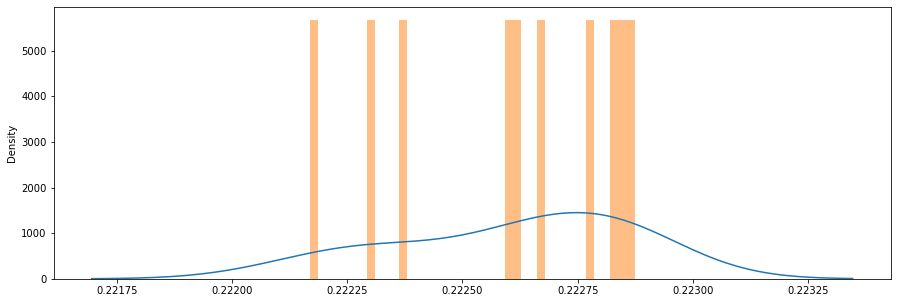

In [7]:
plt.figure(figsize = [15,5])
plt.hist(AP_test_list, bins = 40, density=True, alpha = 0.5, label = 'test', color = 'C1')
sns.kdeplot(AP_test_list)
plt.show()

In [8]:
hp_df = pd.DataFrame({'n_estimators' : n_estimators_list, 'max_depth' : max_depth_list, 'min_samples_split' : min_samples_split_list,
                      'w0' : W_feature0_list, 'w1' : W_feature1_list, 
                      'criterion' : criterion_list, 'class_weight' : class_weight_list, 'max_features' : max_features_list,  
                      'test_preds' : test_preds, 'AP' : AP_test_list})

/home/simon/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/simon/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


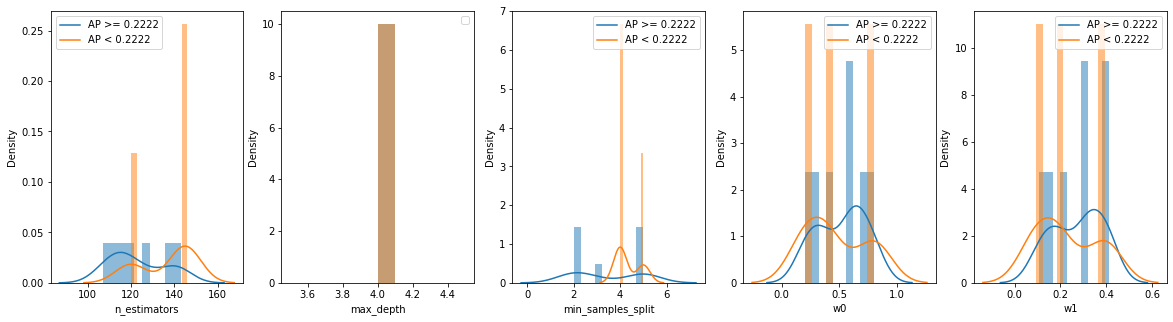

In [9]:
plt.figure(figsize = [20,5])

for i,j in enumerate(hp_df.columns[:5]):
    plt.subplot(1,5,i+1)

    sns.kdeplot(hp_df[hp_df['AP'] >= 0.2225][j], label = 'AP >= 0.2222', bw_method= 0.5) 
    sns.kdeplot(hp_df[hp_df['AP'] < 0.2225][j], label = 'AP < 0.2222', bw_method= 0.5)

    plt.hist(hp_df[hp_df['AP'] >= 0.2225][j], color = 'C0', density = True, alpha = 0.5) 
    plt.hist(hp_df[hp_df['AP'] < 0.2225][j], color = 'C1', density = True, alpha = 0.5)

    plt.legend()

plt.show()

#  I have looked at hte other parameters and there does not appear to be a relationship

# plt.scatter(hp_df['w0'], hp_df['w1'], c= hp_df['AP'])
# plt.xlabel('w0')
# plt.ylabel('w1')

# x_grid = np.arange(0.1,1.1,0.1)
# y_grid = x_grid * 0.52

# plt.plot(x_grid, y_grid)

# plt.show()

good values:
n_estimators: 

In [10]:
hp_df.sort_values('AP', ascending= False)[:5]

,n_estimators,max_depth,min_samples_split,w0,w1,criterion,class_weight,max_features,test_preds,AP
0,119,4,2,0.7,0.382781,gini,"{0: 0.7000000000000001, 1: 0.38278095677983603}",log2,"[0.0006709165118195564, 0.0006709165118195564,...",0.222874
7,115,4,5,0.3,0.164314,gini,"{0: 0.30000000000000004, 1: 0.1643143297512747}",log2,"[0.0006611204104565992, 0.0006611204104565992,...",0.222843
1,113,4,3,0.6,0.317162,gini,"{0: 0.6000000000000001, 1: 0.3171617577616762}",sqrt,"[0.0006505466678960772, 0.0006505466678960772,...",0.222836
4,126,4,5,0.2,0.107899,gini,"{0: 0.2, 1: 0.10789895999375386}",log2,"[0.0006829542789681143, 0.0006829542789681143,...",0.222781
8,143,4,2,0.6,0.310783,gini,"{0: 0.6000000000000001, 1: 0.3107829227252043}",auto,"[0.0006714862269962397, 0.0006714862269962397,...",0.222678


In [11]:
os.system("mpg123 /home/simon/Music/sounds/FF7Victory.mp3")

0

So from here you don't really have to pickle anything... Can you pickle a generator?

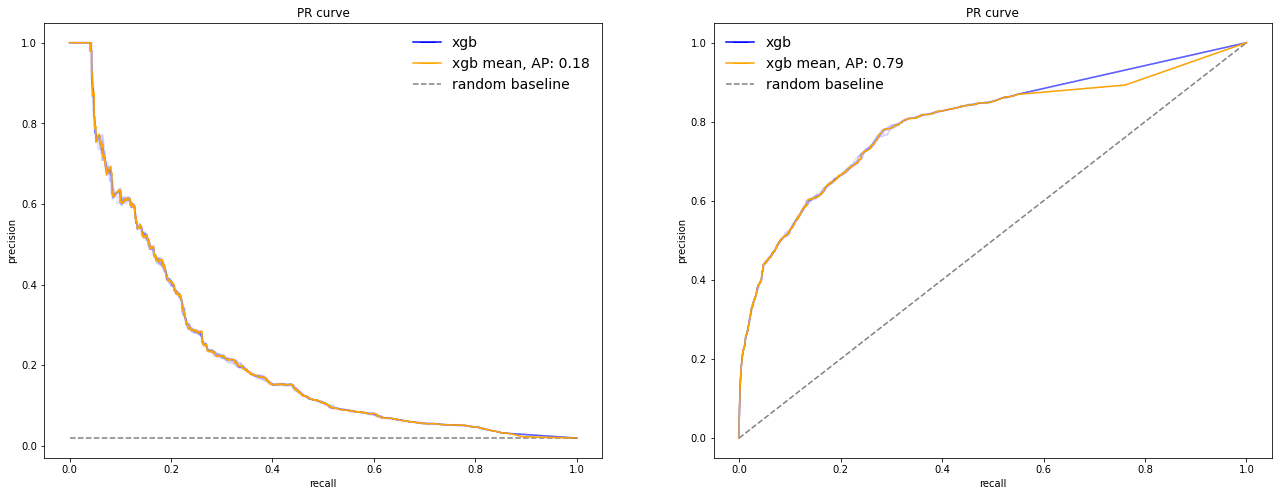

In [17]:
rf_pred_mean = np.array(hp_df['test_preds']).mean(axis = 0)
rf_pred_std = np.array(hp_df['test_preds']).std(axis = 0)

random_ap_base = (y_test>0).mean()
rf_mean_precision, rf_mean_recall, _ = metrics.precision_recall_curve(y_test, rf_pred_mean) 
rf_mean_AP = metrics.average_precision_score(y_test, rf_pred_std)

rf_mean_fpr, rf_mean_tpr, _ =  metrics.roc_curve(y_test, rf_pred_mean) 
rf_mean_AUC = metrics.roc_auc_score(y_test, rf_pred_mean)

# -------------------------------------------------------------------------
# Fig
plt.figure(figsize = [22,8])

# ---------------------------------------------------------------------------
#PR/AP
plt.subplot(1,2,1)

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.hlines(random_ap_base, 0, 1, linestyles='dashed', color = 'gray')

for i in pr_test_list: 
    
    plt.plot(i[1], i[0], color = 'blue', alpha = 0.1)
    
plt.plot(rf_mean_recall,rf_mean_precision, color = 'orange', alpha = 1)

    
rf_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
rf_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label=f'xgb mean, AP: {rf_mean_AP:.2}')
random_ap_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')

plt.legend(handles=[rf_line, rf_mean_line, random_ap_line],frameon = False, fontsize = 14)


# ---------------------------------------------------------------------------
#ROC/AUC
plt.subplot(1,2,2)

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

for i in roc_test_list: 
    
    plt.plot(i[0], i[1], color = 'blue', alpha = 0.1)
    
plt.plot(rf_mean_fpr,rf_mean_tpr, color = 'orange', alpha = 1)

    
rf_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
rf_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label=f'xgb mean, AP: {rf_mean_AUC:.2}')
random_auc_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')

plt.legend(handles=[rf_line, rf_mean_line, random_auc_line],frameon = False, fontsize = 14)

plt.show()
